# PID Tumbling to stablised controller

Adapted PID controller where the error is the difference in angular velocity between the current and setpoint

Step 0.0 / 5000.0
Step 1.0 / 5000.0
Step 2.0 / 5000.0
Step 3.0 / 5000.0
Step 4.0 / 5000.0
Step 5.0 / 5000.0
Step 6.0 / 5000.0
Step 7.0 / 5000.0
Step 8.0 / 5000.0
Step 9.0 / 5000.0
Step 10.0 / 5000.0
Step 11.0 / 5000.0
Step 12.0 / 5000.0
Step 13.0 / 5000.0
Step 14.0 / 5000.0
Step 15.0 / 5000.0
Step 16.0 / 5000.0
Step 17.0 / 5000.0
Step 18.0 / 5000.0
Step 19.0 / 5000.0
Step 20.0 / 5000.0
Step 21.0 / 5000.0
Step 22.0 / 5000.0
Step 23.0 / 5000.0
Step 24.0 / 5000.0
Step 25.0 / 5000.0
Step 26.0 / 5000.0
Step 27.0 / 5000.0
Step 28.0 / 5000.0
Step 29.0 / 5000.0
Step 30.0 / 5000.0
Step 31.0 / 5000.0
Step 32.0 / 5000.0
Step 33.0 / 5000.0
Step 34.0 / 5000.0
Step 35.0 / 5000.0
Step 36.0 / 5000.0
Step 37.0 / 5000.0
Step 38.0 / 5000.0
Step 39.0 / 5000.0
Step 40.0 / 5000.0
Step 41.0 / 5000.0
Step 42.0 / 5000.0
Step 43.0 / 5000.0
Step 44.0 / 5000.0
Step 45.0 / 5000.0
Step 46.0 / 5000.0
Step 47.0 / 5000.0
Step 48.0 / 5000.0
Step 49.0 / 5000.0
Step 50.0 / 5000.0
Step 51.0 / 5000.0
Step 52.0 / 5000.0
Ste

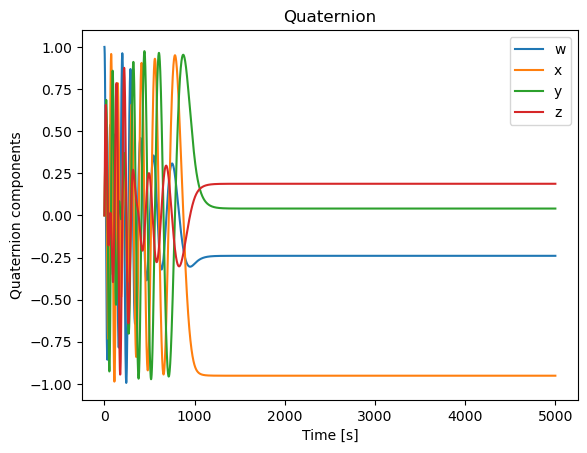

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Quaternion product
def quaternion_product(q, p):
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = p
    return np.array([
        w0*w1 - x0*x1 - y0*y1 - z0*z1,
        w0*x1 + x0*w1 + y0*z1 - z0*y1,
        w0*y1 - x0*z1 + y0*w1 + z0*x1,
        w0*z1 + x0*y1 - y0*x1 + z0*w1
    ])

# Quaternion conjugate
def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

# PID control torque calculation using omega errors
def pid_control(omega, target_omega, integral_error, prev_error, dt):
    error = target_omega - omega  # Angular velocity error
    
    integral_error += error * dt
    derivative_error = (error - prev_error) / dt
    
    control_torque = (Kp * error + Ki * integral_error + Kd * derivative_error)

    #add bounds for the control torques should just use np.clip
    if control_torque[0] > 0.25:
        control_torque[0] = 0.25
    elif control_torque[0] < -0.25:
        control_torque[0] = -0.25

    if control_torque[1] > 0.25:
        control_torque[1] = 0.25
    elif control_torque[1] < -0.25:
        control_torque[1] = -0.25
    
    if control_torque[2] > 0.25:
        control_torque[2] = 0.25
    elif control_torque[2] < -0.25:
        control_torque[2] = -0.25

    return control_torque, integral_error, error

# Dynamics function with PID control
def dynamics(state, integral_error, prev_error, dt):
    q = state[:4]  # Quaternion part
    omega = state[4:]  # Angular velocity part
    
    # Quaternion kinematics
    dqdt = 0.5 * quaternion_product(q, np.append([0], omega))  # dqdt is the quaternion derivative
    
    # PID control torque
    total_torque, integral_error, prev_error = pid_control(omega, target_omega, integral_error, prev_error, dt)
    

    # Euler's rotational equations with control torque
    omega_cross_I_omega = np.cross(omega, I @ omega)
    dwdt = inv_I @ (total_torque - omega_cross_I_omega)  # dwdt is the angular acceleration
    
    return np.concatenate([dqdt, dwdt]), integral_error, prev_error

# RK4 integration method
def rk4_step(state, integral_error, prev_error, dt):
    k1, integral_error, prev_error = dynamics(state, integral_error, prev_error, dt)
    k2, _, _ = dynamics(state + 0.5 * dt * k1, integral_error, prev_error, dt)
    k3, _, _ = dynamics(state + 0.5 * dt * k2, integral_error, prev_error, dt)
    k4, _, _ = dynamics(state + dt * k3, integral_error, prev_error, dt)

    new_state = state + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state, integral_error, prev_error

# Constants (example values for the moments of inertia)
Ix, Iy, Iz = 1191, 1844, 1798
I = np.diag([Ix, Iy, Iz])  # Inertia matrix
inv_I = np.linalg.inv(I)

# PID controller gains
Kp = np.array([30.0, 30.0, 30.0])
Ki = np.array([0.0, 0.0, 0.0])
Kd = np.array([10.0, 10.0, 10.0])

# Initial conditions
q0 = np.array([1, 0, 0, 0])  # Initial quaternion (no rotation)
q0 = q0 / np.linalg.norm(q0)  # Normalize quaternion
omega0 = np.array([0.1, 0.08, 0.15])   # Initial angular velocity 

target_omega = np.array([0, 0, 0])  # Target angular velocity
state0 = np.concatenate([q0, omega0])

# Simulation parameters
t_span = (0, 5000)  # Time span for the simulation
dt = 1
t_eval = np.arange(t_span[0], t_span[1], dt)

# Initialize PID errors
integral_error = np.zeros(3)
prev_error = np.zeros(3)

# Initialize state
state = state0.copy()
quaternion_history = []
angular_velocity_history = []
control_torque_history = []
time_history = []

# RK4 integration loop
for t in t_eval:
    quaternion_history.append(state[:4].copy())
    angular_velocity_history.append(state[4:].copy())
    time_history.append(t)
    # Compute control torques for plotting
    control_torque, _, _ = pid_control(state[4:], target_omega, integral_error, prev_error, dt)
    control_torque_history.append(control_torque)

    # Update state with RK4
    state, integral_error, prev_error = rk4_step(state, integral_error, prev_error, dt)
    # print an update every step
    print(f'Step {t:.1f} / {t_span[1]:.1f}')
    # Normalize quaternion
    state[:4] /= np.linalg.norm(state[:4])

# Convert histories to numpy arrays
quaternion_history = np.array(quaternion_history)
angular_velocity_history = np.array(angular_velocity_history)
control_torque_history = np.array(control_torque_history)

# Plotting the results
plt.figure()
plt.plot(t_eval*dt, quaternion_history[:, 0], label='w')
plt.plot(t_eval*dt, quaternion_history[:, 1], label='x')
plt.plot(t_eval*dt, quaternion_history[:, 2], label='y')
plt.plot(t_eval*dt, quaternion_history[:, 3], label='z')
plt.legend()
plt.title('Quaternion')
plt.xlabel('Time [s]')
plt.ylabel('Quaternion components')
plt.show()


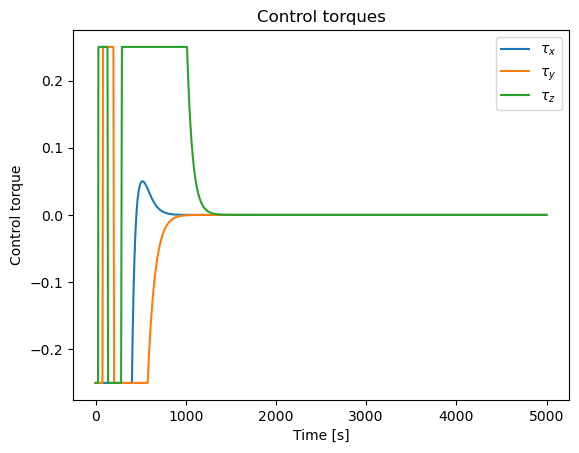

In [41]:
# Plot the control torques
plt.figure()
plt.plot(t_eval*dt, control_torque_history)
plt.title('Control torques')
plt.xlabel('Time [s]')
plt.ylabel('Control torque')
plt.legend(['$\\tau_x$', '$\\tau_y$', '$\\tau_z$'])
plt.show()

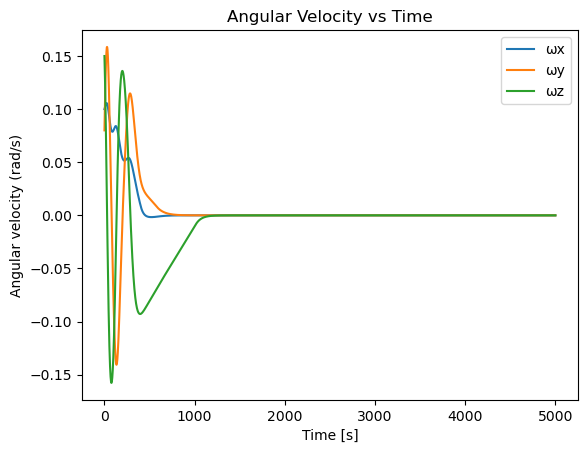

In [42]:
# Plotting the angular velocity
plt.figure()
plt.plot(t_eval*dt, angular_velocity_history[:, 0], label='ωx')
plt.plot(t_eval*dt, angular_velocity_history[:, 1], label='ωy')
plt.plot(t_eval*dt, angular_velocity_history[:, 2], label='ωz')
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity (rad/s)')
plt.title('Angular Velocity vs Time')
plt.legend()
plt.show()


In [43]:
# save to csv
import pandas as pd
from datetime import datetime
# Exporting the data into a csv file
def save_simulation_to_csv(filename):
    data = {
        'time': time_history,
        'q0': quaternion_history[:, 0],
        'q1': quaternion_history[:, 1],
        'q2': quaternion_history[:, 2],
        'q3': quaternion_history[:, 3],
        'omega_x': angular_velocity_history[:, 0],
        'omega_y': angular_velocity_history[:, 1],
        'omega_z': angular_velocity_history[:, 2],
        'Total_torque_x': control_torque_history[:, 0],
        'Total_torque_y': control_torque_history[:, 1],
        'Total_torque_z': control_torque_history[:, 2],
    }
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = f"satellite_attitude_control_PID_RK4_Detumble_withBounds_{date_time}.csv"
save_simulation_to_csv(file_name)